In [1]:
%pip install jsonlines
%pip install sparqlwrapper
%pip install tqdm

import os
import json

from SPARQLWrapper import SPARQLWrapper, JSON
import jsonlines

# Get dict of all predicate labels 

In [57]:
trex_dir = "../TREx"
pid_list = []

for f in os.listdir(trex_dir):
    with open(os.path.join(trex_dir, f)) as json_file:
        f_content = list(json_file)
    pid = json.loads(f_content[0])["predicate_id"]
    pid_list += [pid]

assert len(pid_list) == 41

In [58]:
user_agent = 'AGENT NAME' ## Customize
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)

In [ ]:
pid_name_labels = {}
for pid in pid_list:
    search_item = f"{{(wdt:{pid})}}"
    service = """{ bd:serviceParam wikibase:language "en". }"""
    sparql.setQuery(f""" 
                    SELECT ?wdLabel WHERE 
    {{
                    VALUES (?wdt) {search_item}
                    ?wd wikibase:directClaim ?wdt .
                    SERVICE wikibase:label {service}
    }}
    """)
    sparql.setReturnFormat(JSON)
    query_result = sparql.query().convert()
    try:
        pid_name_labels[pid] = query_result["results"]["bindings"][0]["wdLabel"]["value"]
    except:
        pass
  

In [ ]:
pid_name_labels

In [ ]:
with open("predicate_labels.json", "w") as f:
    json.dump(pid_name_labels, f)

# Analyze distributions

In [2]:
%pip install pandas

import pandas as pd

### Create tables for locations and languages including essential information for later analysis

In [3]:
location_predicates_obj = ["P36", "P740", "P190", "P27", "P47", "P1376", "P937", "P131", "P20", "P276", "P19", "P17", "P159", "P495", "P1001", "P30"]
location_predicates_sub = ["P36", "P190", "P1376", "P131", "P47", "P37", "P30"]
person_predicates_sub = ["P108", "P27", "P937", "P20", "P19", "P101", "P103", "P1412", "P106", "P413"] 
language_predicates_obj = ["P407", "P103", "P37", "P364", "P1412"]

In [4]:
with open("predicate_labels.json", "r") as json_file:
    pid_name_labels = json.load(json_file)

In [5]:
trex_dir = "../TREx"

In [6]:
trex_locations = []

for p in set(location_predicates_obj + location_predicates_sub):
    with open(os.path.join(trex_dir, f"{p}.jsonl")) as json_file:
        f_content = list(json_file)
    for l in f_content:
        list_item = json.loads(l)
        pid = list_item["predicate_id"]
        trex_locations += [{
            "uuid" : list_item["uuid"],
            "predicate_id" : pid, 
            "predicate_label": pid_name_labels[pid],
            "obj_label" : list_item["obj_label"],
            "sub_label" : list_item["sub_label"],
            "location_is_obj" : p in location_predicates_obj,
            "location_is_sub" : p in location_predicates_sub,
            "obj_uri" : list_item["sub_uri"],
            "sub_uri" : list_item["sub_uri"],
            }]

trex_locations_df = pd.DataFrame(trex_locations)
trex_locations_df.to_csv("trex_locations_uuid.csv")


In [7]:
trex_languages = []

for p in set(language_predicates_obj):
    with open(os.path.join(trex_dir, f"{p}.jsonl")) as json_file:
        f_content = list(json_file)
    for l in f_content:
        list_item = json.loads(l)
        pid = list_item["predicate_id"]
        trex_languages += [{
            "uuid" : list_item["uuid"],
            "predicate_id" : pid, 
            "predicate_label": pid_name_labels[pid],
            "obj_label" : list_item["obj_label"],
            "sub_label" : list_item["sub_label"],
            "sub_uri" : list_item["sub_uri"]
            # all language-related items are subjects in the templates
            }]

trex_languages_df = pd.DataFrame(trex_languages)
trex_languages_df.to_csv("trex_languages.csv")


Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='obj_label'>

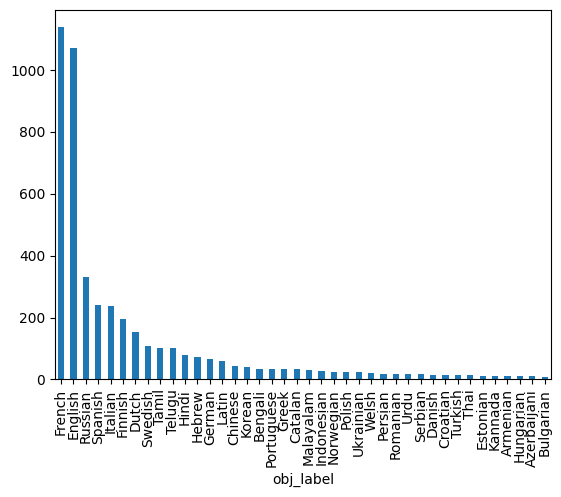

In [91]:
%pip install matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
trex_languages_df["obj_label"].value_counts()[:40].plot(ax=ax, kind='bar')

### Get person entities and add gender information

In [8]:
# Load gender map: Maps Wikidata gender ids to labels (str)
path_to_gender_map = "PATH-TO/wikidata_genders.json" ## Customize
with open(path_to_gender_map, "r") as f:
    gender_map = json.load(f)["map"] 

# Get local file with list of Wikidata entities including gender info
path_to_wiki_entities = "PATH-TO/wikidata_all_human_entities.jsonl" ## Customize
with open(path_to_wiki_entities) as json_file:
    wikidata_entity_list = list(json_file)

In [10]:
# Make entity list simpler for better querying of gender: maps person id to gender id
simple_entity_list = {}
for entity in wikidata_entity_list:
    entity = json.loads(entity)
    simple_entity_list[entity["entity_id"]] = entity["gender"]

In [11]:
user_agent = 'AGENT NAME' ## Customize
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)

def get_entity_gender_from_wikidata(entity_uri):
    # Query gender through SPARQL if person id is not in the local dump
    sparql.setQuery(f""" 
    SELECT * WHERE {{
    wd:{entity_uri} wdt:P21 ?gender .
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """)
    sparql.setReturnFormat(JSON)
    query_result = sparql.query().convert()
    try:
        return query_result["results"]["bindings"][0]["gender"]["value"].split("/")[-1]
    except:
        return "NaN"

def get_gender_of_entity(entity_uri):
    # Get gender information for a specific person entity
    gender_id = simple_entity_list.get(entity_uri, "NaN")
    if gender_id == "NaN":
        gender_id = get_entity_gender_from_wikidata(entity_uri)
        if gender_id == "NaN":
            print("No gender info available for", entity_uri)
    gender_string = gender_map.get(gender_id, "NaN")
    return gender_string
    

In [13]:
# Make list of dicts with person entity infos
trex_people = []

for p in set(person_predicates_sub):
    with open(os.path.join(trex_dir, f"{p}.jsonl")) as json_file:
        f_content = list(json_file)
    for l in f_content:
        list_item = json.loads(l)
        pid = list_item["predicate_id"]
        uri = list_item["sub_uri"]
        trex_people += [{
            "uuid" : list_item["uuid"],
            "predicate_id" : pid, 
            "predicate_label": pid_name_labels[pid],
            "obj_label" : list_item["obj_label"],
            "sub_label" : list_item["sub_label"],
            "sub_uri" : uri,
            # all person-related items are subjects in the templates
            "gender" : get_gender_of_entity(uri)
            }]

No gender info available for Q7427317
No gender info available for Q49542
No gender info available for Q622283
No gender info available for Q1998273
No gender info available for Q18913178
No gender info available for Q1192364
No gender info available for Q165192
No gender info available for Q1673765
No gender info available for Q311762
No gender info available for Q1057292
No gender info available for Q1673765
No gender info available for Q5639595
No gender info available for Q378422
No gender info available for Q7916974
No gender info available for Q5605925
No gender info available for Q179132
No gender info available for Q1454986
No gender info available for Q4612907
No gender info available for Q47913
No gender info available for Q580606
No gender info available for Q44703
No gender info available for Q1379239
No gender info available for Q179677
No gender info available for Q46857
No gender info available for Q2125835
No gender info available for Q920064
No gender info available fo

In [14]:
# Make table and store
trex_locations_df = pd.DataFrame(trex_people)
trex_locations_df.to_csv("trex_persons.csv")

In [15]:
trex_locations_df["gender"].value_counts()

gender
male               7494
female             1146
NaN                 107
non-binary            2
trans woman           2
female organism       1
Name: count, dtype: int64

### Analyze geospatial distribution (WIP)

Tutorial: https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

In [2]:
%pip install pycountry-convert
%pip install geopy
%pip install numpy

In [3]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()


In [4]:
# load previously extracted location info
trex_locations_df = pd.read_csv("trex_locations.csv")

In [22]:
geolocator = Nominatim(user_agent="trex_eda")
def geolocate(location, timeout):
    try:        
        # Geolocate the center of the country
        if timeout == "default":
            loc = geolocator.geocode(location)
        else:
            loc = geolocator.geocode(location, timeout=timeout)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return "NaN"

In [29]:
def get_geolocation_for_row(row, timeout):
    if row["location_is_sub"]:
        row["geolocation_sub"] = geolocate(row["sub_label"], timeout)
    else:
        row["geolocation_sub"] = "NaN"
    if row["location_is_obj"]:
        row["geolocation_obj"] = geolocate(row["obj_label"], timeout)
    else:
        row["geolocation_obj"] = "NaN"
    return row

def get_geolocations_for_df(df, start_idx=0, end_idx=-1, index_list=None, timeout="default"):
    if index_list:
        return df.iloc[index_list].apply(get_geolocation_for_row, args=[timeout], axis=1)
    else:
        return df.iloc[start_idx:end_idx].apply(get_geolocation_for_row, args=[timeout], axis=1)

In [30]:
import threading

# Optionally speed up things through multi-threading

class ThreadWithReturnValue(threading.Thread):

    def __init__(self, group=None, target=None, name=None,
                    args=(), kwargs={}, Verbose=None):
        threading.Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        threading.Thread.join(self, *args)
        return self._return


In [31]:

thread1 = ThreadWithReturnValue(target=get_geolocations_for_df, args=(trex_locations_df, 0, 3723))
thread2 = ThreadWithReturnValue(target=get_geolocations_for_df, args=(trex_locations_df, 3723, 7446))
thread3 = ThreadWithReturnValue(target=get_geolocations_for_df, args=(trex_locations_df, 7446, 11169))
thread4 = ThreadWithReturnValue(target=get_geolocations_for_df, args=(trex_locations_df, 11169, -1))
thread1.start()
thread2.start()
thread3.start()
thread4.start()
trex_locations_df = pd.concat([thread1.join(), thread2.join(), thread3.join(), thread4.join()], axis=0, ignore_index=True)

In [36]:
trex_locations_df.to_csv("trex_locations.csv") # This will be overwritten later
trex_locations_df.to_csv("trex_locations_backup.csv") # Back-up in case sth. goes wrong :)

Due to the fast default timeout in the geolocate function, a couple thousand unresolved locations remain. Re-running geolocate for all unresolved location and add to df:

In [ ]:
# Get all cases where coordinates should exist but weren't resolved so far
unresolved_indices = trex_locations_df.index[(trex_locations_df["geolocation_sub"].apply(isinstance, args=(tuple,)) == False) & (trex_locations_df["geolocation_obj"].apply(isinstance, args=(tuple,)) == False)].tolist()
len(unresolved_indices)

In [47]:
# Geolocate with longer timeout (did this in two iterations: 3 and then 10)
trex_locations_df.iloc[unresolved_indices] = get_geolocations_for_df(trex_locations_df, index_list=unresolved_indices, timeout=3)

In [49]:
# Overwrite location table
trex_locations_df.to_csv("trex_locations.csv")


## Create disaggregated datasets in T-REx format

In [76]:
import os
import json

### Gender

In [52]:
# Make subfolders to store disaggregated datasets
out_dir = "../TREx-disaggregated"
gender_list = ["male", "female"]
for gender in gender_list:
    os.makedirs(os.path.join(out_dir, gender), exist_ok=True)

# Load file that contains gender info extracted earlier
trex_persons_df = pd.read_csv("trex_persons.csv")

# Path to original TREx data
trex_path = "../TREx/"

In [74]:
for predicate in trex_persons_df.groupby("predicate_id"):
    predicate_id = predicate[0]
    pred_file_name = f"{predicate_id}.jsonl"

    female_uuids = predicate[1].loc[predicate[1]["gender"] == "female", "uuid"].tolist()
    male_uuids = predicate[1].loc[predicate[1]["gender"] == "male", "uuid"].tolist()
    female_outdir = os.path.join(out_dir, "female")
    male_outdir = os.path.join(out_dir, "male")

    # Load original TREx file
    with open(os.path.join(trex_dir, pred_file_name)) as json_file:
        original_content = list(json_file)

    female_list, male_list = [], []

    for line in original_content:
        item = json.loads(line)
        if item["uuid"] in female_uuids:
            female_list += [item]
        elif item["uuid"] in male_uuids:
            male_list += [item]
    
    for outdir, item_list in zip([female_outdir, male_outdir], [female_list, male_list]):
        with open(os.path.join(outdir, pred_file_name), "w") as f:
            for item in item_list:
                json.dump(item, f)
                f.write('\n')           
                    
            
    

### Locations clustered by region

In [94]:
# Load file that contains location info extracted earlier
trex_locations_df = pd.read_csv("trex_locations.csv")
trex_locations_df

,Unnamed: 0,uuid,predicate_id,predicate_label,obj_label,sub_label,location_is_obj,location_is_sub,obj_uri,sub_uri,Unnamed: 0_y,geolocation_sub,geolocation_obj
0,0,cb7007d9-673f-4fa5-8308-ddf2ae28b8c2,P36,capital,Baku,Azerbaijan,True,True,Q227,Q227,4836,"(40.3936294, 47.7872508)","(40.163999149999995, 50.27770925520258)"
1,1,0994628e-262a-40cd-96f6-578358f299b9,P36,capital,Brody,Brody Raion,True,True,Q2599799,Q2599799,4837,"(50.06244985, 25.05890105312845)","(50.0833041, 25.1437921)"
2,2,4168a6fb-d710-4678-93f9-9447927a0a35,P36,capital,Chicago,Cook County,True,True,Q108418,Q108418,4838,NaN,"(41.8755616, -87.6244212)"
3,3,9e0027e7-1efc-4d79-a8c0-1a3ed0e8a00a,P36,capital,Richmond,Fort Bend County,True,True,Q26895,Q26895,4839,"(29.511218, -95.7807348)",NaN
4,4,b2b50148-a91a-4aa9-9936-13ae0212afa9,P36,capital,Auburn,Cayuga County,True,True,Q115182,Q115182,4840,"(42.8093409, -76.5700777)","(32.6405377, -85.4626848)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11168,11168,e09bb7c3-f5b3-49d4-871a-ef3ad2bc94a5,P17,country,Finland,Christian Democrats,True,False,Q1138982,Q1138982,11166,NaN,"(63.2467777, 25.9209164)"
11169,11169,256bf53c-e2e5-45cd-b0bf-c06e23a84443,P17,country,Netherlands,IJmuiden,True,False,Q282461,Q282461,11167,NaN,"(52.2434979, 5.6343227)"
11170,11170,5c8a9826-336c-4e8c-a1fe-a440c450ed21,P17,country,Norway,Ankenes,True,False,Q1770618,Q1770618,11168,NaN,"(61.1529386, 8.7876653)"
11171,11171,a28d66d3-aeab-437d-a2d1-49aea8eac0b9,P17,country,Morocco,Haut Atlas,True,False,Q584279,Q584279,11169,NaN,"(31.1728205, -7.3362482)"


In [98]:
%pip install shapely geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 11.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [159]:
res = lambda x_str: tuple(list(map(float, x_str[1:-2].split(', ')))[::-1])

/var/folders/df/2d8rjmx139x558sf3tlzhwyc0000gn/T/ipykernel_4353/968355940.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


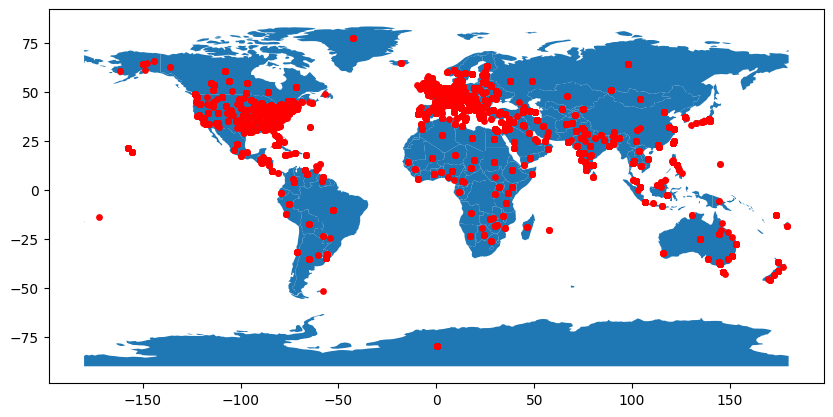

In [161]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(res(x)) for x in trex_locations_df['geolocation_obj'].dropna()]
gdf = GeoDataFrame(trex_locations_df.loc[~trex_locations_df['geolocation_obj'].isna(), 'sub_label'], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

/var/folders/df/2d8rjmx139x558sf3tlzhwyc0000gn/T/ipykernel_4353/509522485.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


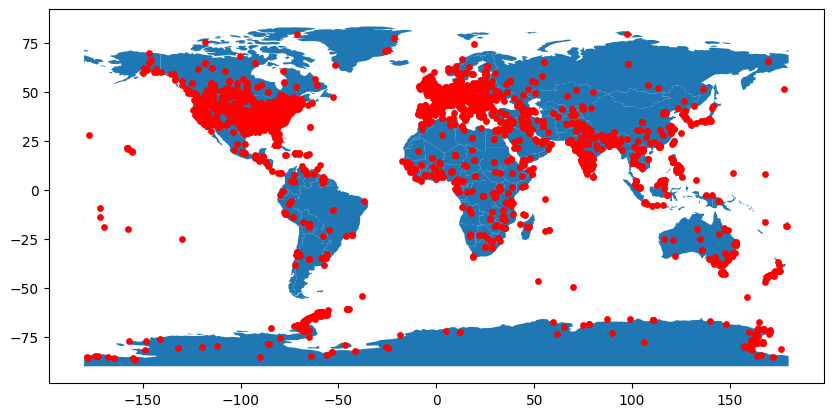

In [163]:
geometry = [Point(res(x)) for x in trex_locations_df['geolocation_sub'].dropna()]
gdf = GeoDataFrame(trex_locations_df.loc[~trex_locations_df['geolocation_sub'].isna(), 'sub_label'], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [162]:
# TODO: get country by coordinate and create clusters 